# Google Lenet test for lungs dataset.
Fine tunning on 5 ephocs

## Load Dataset into a trainloader and transform to 256x256

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
plt.ion()

## Trainer and validator

In [2]:

def train(net, epochs, trainloader, optimizer, criterion=nn.CrossEntropyLoss(), title="", writer=None):
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        val_acc = 0
        running_correct = 0.0
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            if i % 200 == 199:    # print every 200 mini-batches
                if writer:
                    val_acc = validate(net, dataloaders['val'])                

                    writer.add_scalar(
                        'training loss, ' + title, running_loss/200, i*epoch)
                    writer.add_scalar('accuracy, '+title,
                                        running_correct/200,  i*epoch)
                    writer.add_scalar('validation accuracy, '+title,
                                        val_acc,  i*epoch)
                running_loss = 0.0
                running_correct = 0.0

    print('Finished Training')

def validate(net, testloader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print("testing network:")
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader, leave=False):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # print("total accuracy of net: %.2f%%" % (correct/total*100))
    return correct/total

In [3]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_dir = './data/'


image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'),train_transforms),
    'test': datasets.ImageFolder(os.path.join(data_dir,  'test'),test_transforms),
    'val': datasets.ImageFolder(os.path.join(data_dir,  'val'),test_transforms)
}

class_names = image_datasets['train'].classes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'val']}


## Load GoogleLeNet and set output layer to 2

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

NameError: name 'dataloaders' is not defined

In [4]:
trainloader = dataloaders['train']
testloader = dataloaders['test']
valloader = dataloaders['val']

gnet = models.googlenet(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

gnet.fc = nn.Linear(1024, 2)
gnet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:
gnet.load_state_dict(torch.load('models/gnet.pth'))
gnet.to(device)
gnet.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
opt = optim.SGD(gnet.parameters(),lr=1e-4, momentum=0.9)

train(gnet, 5, trainloader, opt, title="Googlelenet",writer=writer)



100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

100%|██████████| 5/5 [38:35<00:00, 463.09s/it]Finished Training



In [9]:
validate(gnet, valloader)


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


0.875

In [11]:
torch.save(gnet.state_dict(), './models/gnet.pth')

In [10]:
validate(gnet, testloader)

100%|██████████| 78/78 [00:21<00:00,  3.61it/s]


0.9551282051282052

In [25]:
opt = optim.SGD(gnet.parameters(),lr=2e-4, momentum=0.9)


train(gnet, 50, trainloader, opt, title="Googlelenet")


100%|██████████| 40/40 [4:15:22<00:00, 383.06s/it]Finished Training



In [27]:
torch.save(gnet.state_dict(), './models/gnetHeavy.pth')
print("validate")
validate(gnet, valloader)
print("test data")
validate(gnet, testloader)

100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


0.9567307692307693

In [62]:
def validate_confusion(net, loader):
    correct = 0
    total = 0
    cmatrix = torch.zeros(2,2, dtype=torch.int)
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).to(device)

            outputs = net(inputs)
            y_pred = torch.round(torch.sigmoid(outputs))
            y = torch.zeros(y_pred.size(0))

            for i in range(y_pred.size(0)):
                y[i] = torch.argmax(y_pred[i])
            y = y.unsqueeze(1)
            stacked = torch.stack((labels, y),dim=1)
            
            for i in stacked:
                act, pre = i.tolist()
                cmatrix[act,pre] = cmatrix[act, pre] + 1
        return cmatrix
    


  0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-62-c266aa149b91>:19: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cmatrix[act,pre] = cmatrix[act, pre] + 1
100%|██████████| 78/78 [00:22<00:00,  3.49it/s]
Confusion matrix, without normalization


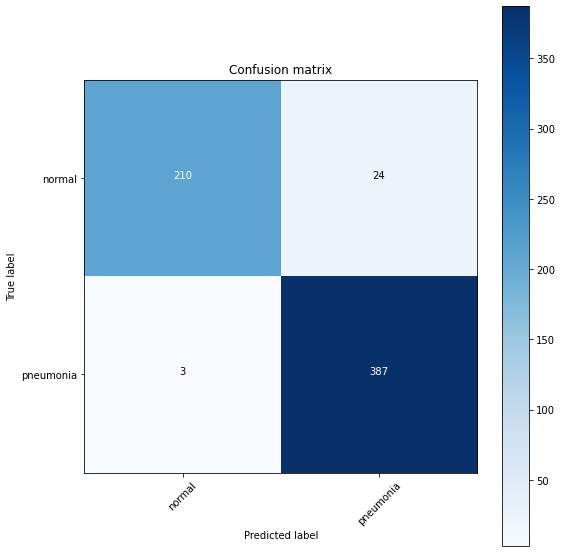

In [63]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # writer.add_figure('Confusion matrix', fig)


test_cmt = validate_confusion(gnet, testloader)

# plot_confusion_matrix(val_cmt, ['normal','pneumonia'])
plt.figure(figsize=(8,8))
plot_confusion_matrix(test_cmt, ['normal','pneumonia'])

In [109]:
# original Github https://github.com/kazuto1011/grad-cam-pytorch/blob/master/main.py
from grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

def get_heatmap(images, target_class=1,target_layers = ["layer1", "layer2", "layer3", "layer4"]):

    gcam = GradCAM(model=gnet)
    pred, _id = gcam.forward(images)
    id_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=_id)

    for i,target_layer in enumerate(target_layers):
        if i == 0:
            regions= gcam.generate(target_layer=target_layer)
        region = (gcam.generate(target_layer=target_layer))
        regions = torch.cat((region, regions), dim=1)
        # print(target_layer, region.size())


    return torch.mean(regions, dim=1).squeeze()

In [102]:
import cv2
import numpy as np


def grad_cam(img, heatmap, txt):
    # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap )
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
    # img = rgb_to_brgb(img , const_alpha)

    img = heatmap * 0.4 + img

    img = cv2.rectangle(img, (5,220), (200, 250), (0,0,0), -1)
    img = cv2.resize(img, (640,480))
    cv2.putText(img, txt,(150,430), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.4, (0,150,100), 1)

    cv2.imshow('image', img)

In [114]:

images, id_ = next(iter(testloader))


test = gnet(images)
test = torch.round(torch.sigmoid(test))

y = torch.zeros(test.size(0))
for i in range(test.size(0)):
    y[i] = torch.argmax(test[i])
test = y.unsqueeze(1)


c = {0: "Normal", 1: "Pnemonia"}

images = images.to(device)
heatmap = get_heatmap(images, target_layers=[ "inception5b","inception5a","inception4b","inception4a","inception4e","inception4d", "inception4c"])

images =  images.permute(0,2,3,1)
images = images.cpu().numpy() 
heatmap = heatmap.cpu().numpy()
heatmap = np.vstack([heatmap])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


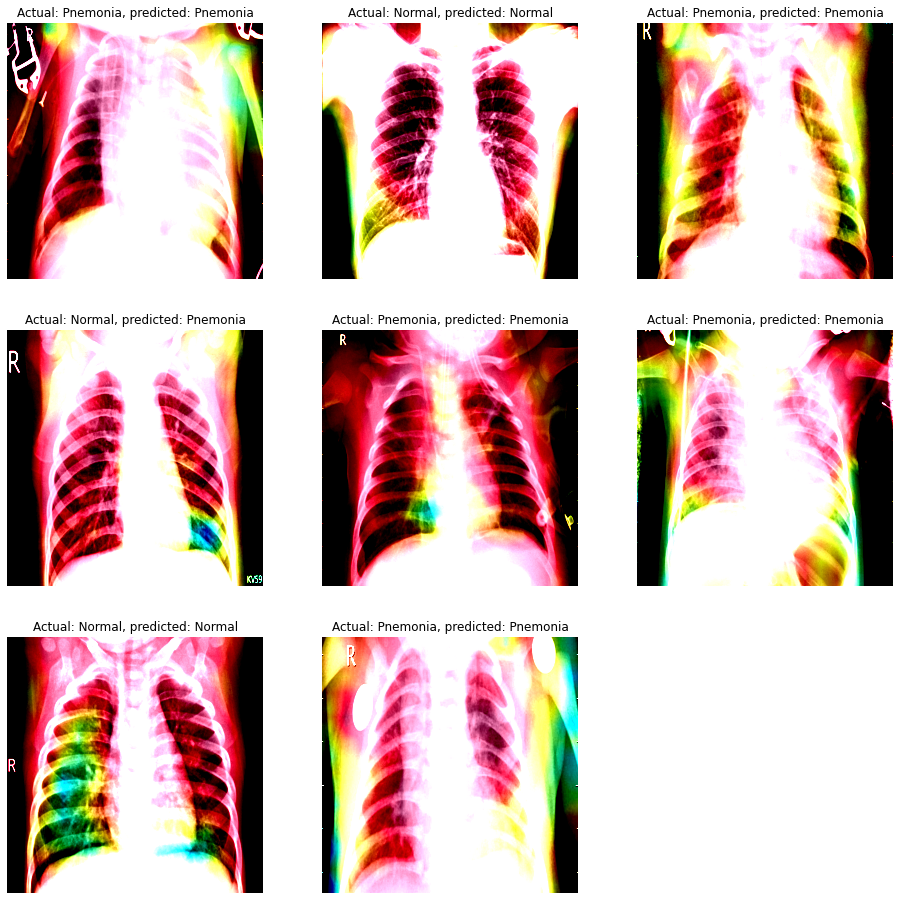

In [115]:
plt.figure(figsize=(16, 16))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    hm = heatmap[i]

    hm = np.uint8(254 *hm + 1)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

    img =hm * 0.0045 + img*(1-0.045)
    plt.imshow(img)
    plt.title(f"Actual: {c[id_[i].item()]}, predicted: {c[test[i].item()]}")
    plt.axis("off")